# Hausaufgabe 5
## Schallerzeugung durch einen umströmten Zylinder (Teil 2)
<!-- Lizensiert unter (CC BY 2.0) Gert Herold, 2020 -->

Bei der Umströmung eines zylindrischen Körpers bilden sich hinter diesem häufig Wirbelstraßen aus.
Je nach Medium, Strömungsgeschwindigkeit und Durchmesser des Zylinders können die gegenläufigen Wirbel wahrnehmbare Töne verursachen.

Zusätzlich zu dem in Hausaufgabe 4 ausgewerteten Messungen wurde die Schallabstrahlung von 9 Zylindern unterschiedlichen Durchmessers bei 13 verschiedenen Strömungsgeschwindigkeiten gemessen und der jeweilige Hiebton bestimmt.
Die Ergebnisse sind in tabellarischer Form in der Datei `vf.csv` eingetragen.

**1) Laden Sie die detektierten Hiebtöne aus der Datei `vf.csv` und visualisieren Sie die Daten.**
  * Stellen Sie in Abb. 1 den Verlauf der Frequenzen über der Strömungsgeschwindigkeit für jeden Durchmesser dar. Zeichnen Sie in dieselbe Abbildungen die gefundenen Hiebtöne aus der letzten HA ein.
  * Stellen Sie in Abb. 2 den Verlauf der Frequenzen über dem Zylinderdurchmesser für jede Strömungsgeschwindigkeit dar.  
  * Stellen Sie in Abb. 3 die Abhängigkeit der Frequenz von sowohl der Strömungsgeschwindigkeit als auch des Zylinderdurchmessers dar (z.B. über einen Konturplot)
  * Fügen Sie jeweils eine aussagekräftige Legende bzw. Farbskala hinzu und achten Sie auf korrekte Achsenbeschriftungen.
  * *Zusatzaufgabe: Lesen Sie neben den Frequenzen auch die Durchmesser-Werte automatisiert ein, anstelle sie per Hand einzugeben.*

Text(0, 0.5, '$v$ in m/s')

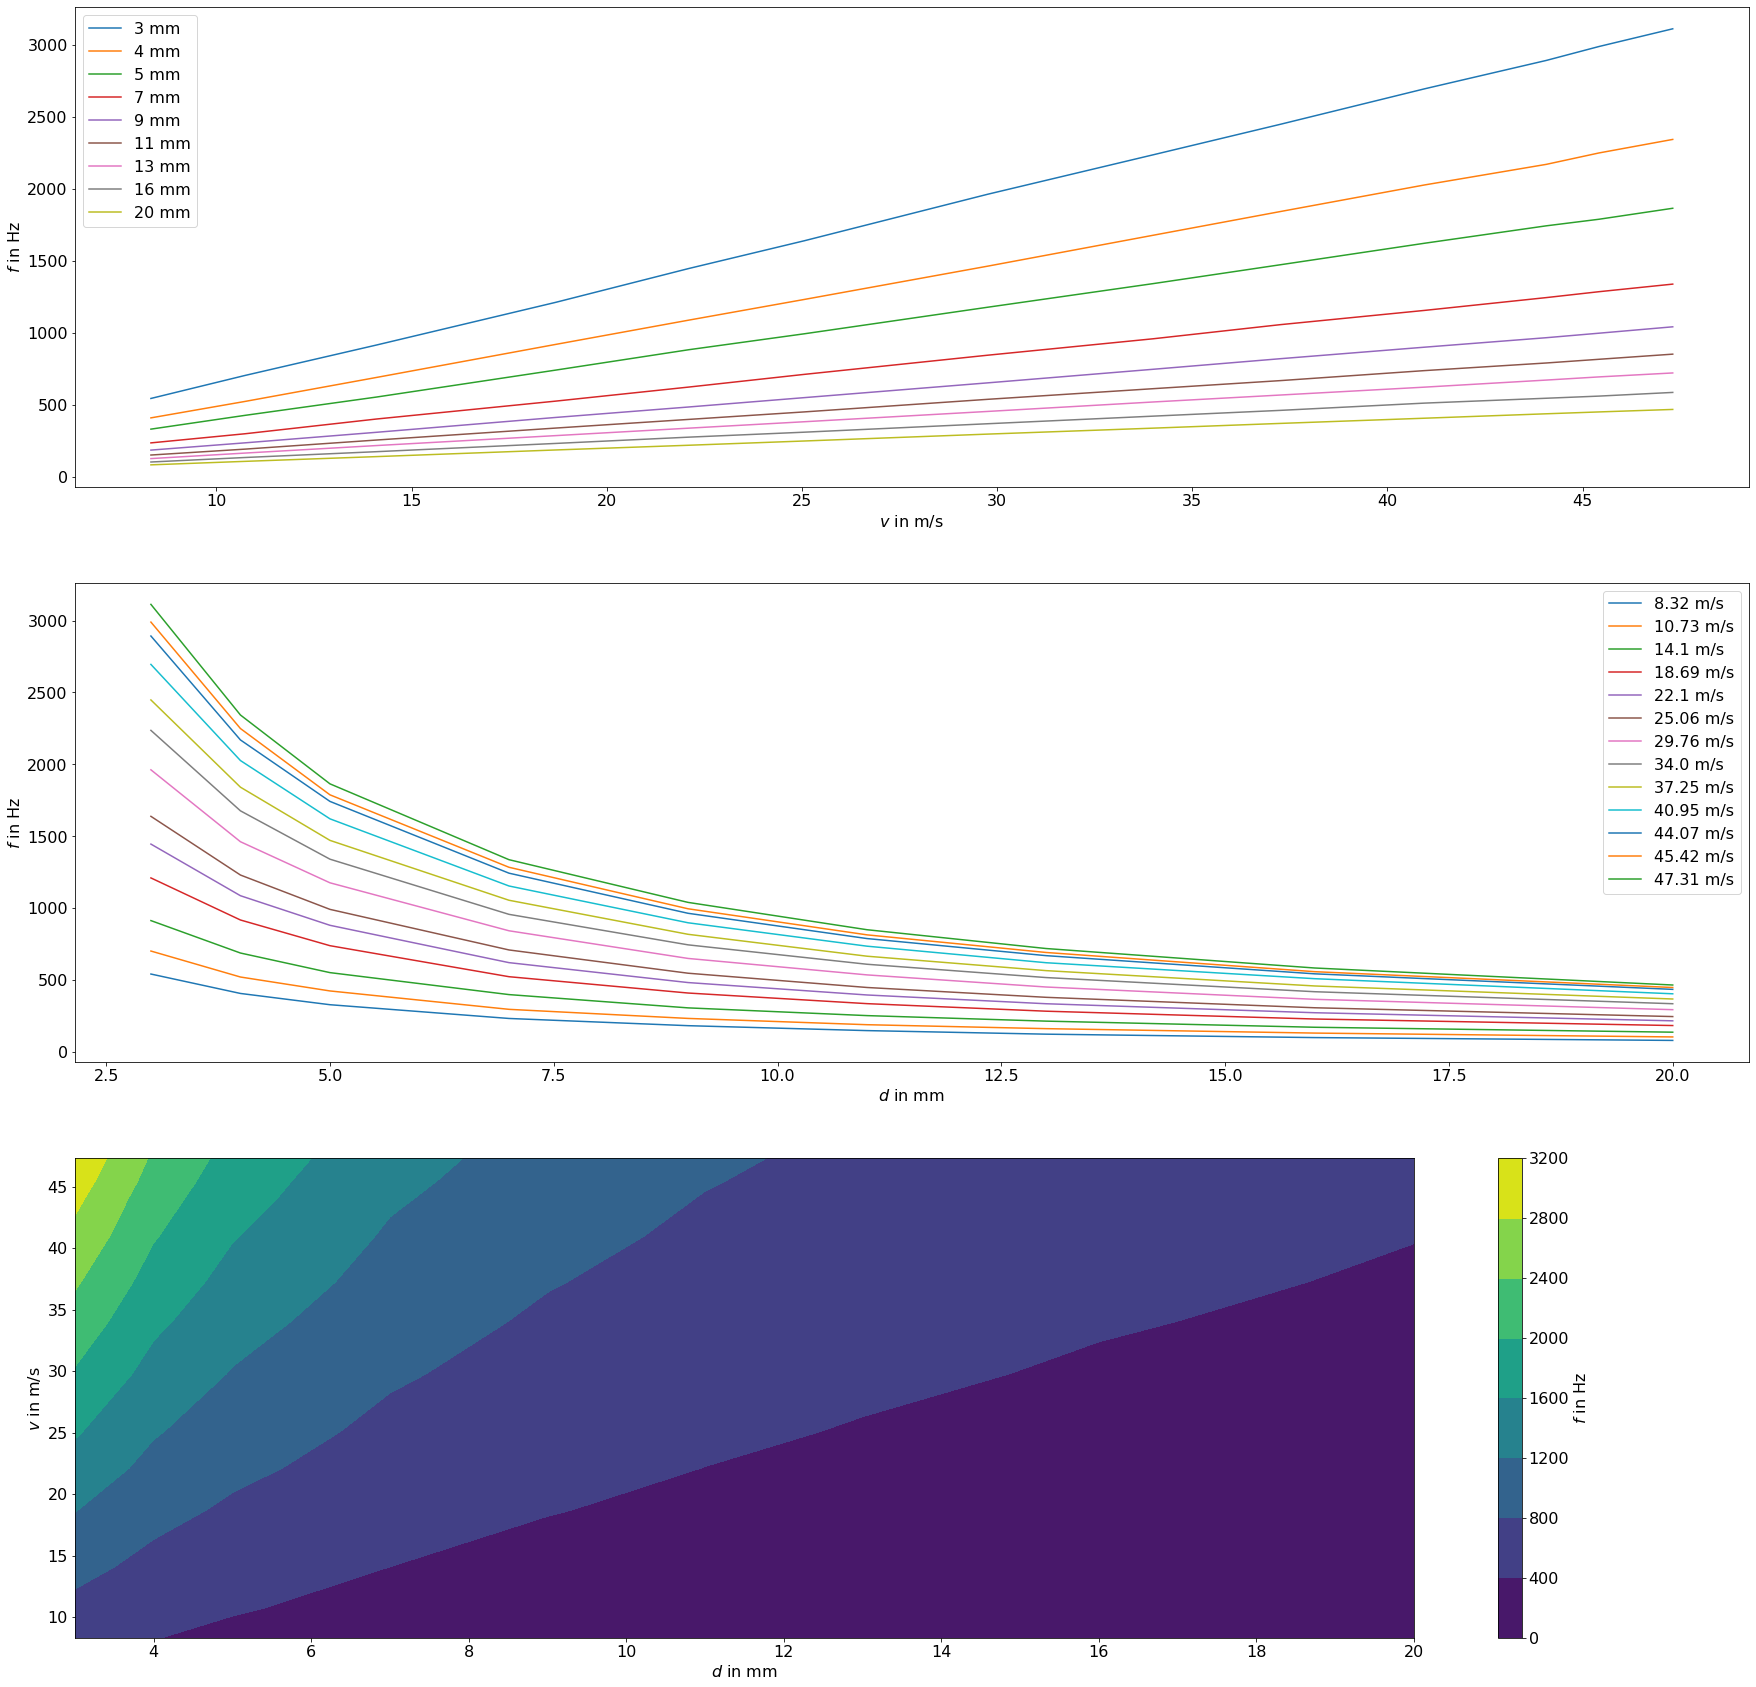

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
plt.rcParams.update({'font.size': 16})

with open("vf.csv", "r") as vf:
    d_line = vf.readlines()[1]

d_line = d_line.split(",")[1:]
d_list = [int(element[element.find("=")+1:element.find("m")]) for element in d_line]
v_list = np.loadtxt("vf.csv", delimiter=",")[:,0]
f_arr = np.loadtxt("vf.csv", delimiter=",")[:,1:]

fig1 = plt.figure(figsize=(30,30))

ax1 = plt.subplot(3,1,1)
for f in f_arr.T:
    plt.plot(v_list,f)
plt.legend(["".join([str(name), " mm"]) for name in d_list])
plt.xlabel("$v$ in m/s")
plt.ylabel("$f$ in Hz")

ax2 = plt.subplot(3,1,2)
for f in f_arr:
    plt.plot(d_list,f)
plt.legend(["".join([str(name), " m/s"]) for name in v_list])
plt.xlabel("$d$ in mm")
plt.ylabel("$f$ in Hz")

ax3 = plt.subplot(3,1,3)
plt.contourf(d_list, v_list, f_arr)
plt.colorbar(shrink=1, label="$f$ in Hz")
plt.xlabel("$d$ in mm")
plt.ylabel("$v$ in m/s")

Die Frequenz des Hiebtons hängt mindestens von den zwei Größen Durchmesser und Geschwindigkeit ab:
$$
f = f(d,v)
$$
Die Abhängigkeit von $v$ (Abb. 1) wurde in HA 4 mittels der Regressionsgerade gefunden. 
Die Abhängigkeit von $d$ (Abb. 2) könnte nach demselben Schema geschehen, allerdings trifft die Annahme einer direkt linearen Abhängigkeit offensichtlich nicht zu.
Außerdem wäre es wünschenswert, beide Parameter einer einzigen Berechnungsformel übergeben zu können.

Im einfachsten Fall mit nur linearen Abhängigkeiten könnten wir schreiben:
$$
f(d,v) = \beta_0 + \beta_1\,d + \beta_2\,v + \epsilon
$$
Die Koeffizienten $\beta_n$ erfüllen denselben Zweck wie $a$ und $b$ aus HA 4. 
$\epsilon$ ist eine Störgröße, die als zufällig angenommen wird und die den Fehler beschreibt, den das Modell z.B. durch unbeobachtbare Abhängigkeiten macht.
Die Lösung eines Problems mithilfe einer solchen Formulierung geschieht über die [multiple lineare Regression](https://de.wikipedia.org/wiki/Multiple_lineare_Regression).

Nichtlineare Abhängigkeiten können mit diesem Schema auch untersucht werden, sofern eine Annahme zur Art der Nichtlinearität getroffen wird, z.B.:
$$
f(d,v) = \beta_1\,d + \beta_2\,v + \beta_3\,d^2 + \ldots + \beta_4\,\frac{d}{v} + \beta_5\,\frac{v}{d} + \ldots + \beta_6\,\sin(v^\sqrt{d}) + \ldots +  \epsilon
$$
Das Modell kann dabei beliebig komplex werden.
Allgemein können wir auch schreiben:
$$
f = \pmb{x} \cdot \pmb{\beta} + \epsilon~,
$$
wobei der Vektor $\pmb{x}$ die charakteristischen Größen wie $d$, $v$ oder daraus abgeleitete Terme enthält (im maschinellen Lernen wird hier auch von *Features* gesprochen) und $\pmb{\beta}$ die zunächst noch unbekannten Koeffizienten.

Natürlich sollen unsere Messdaten (gekennzeichnet mit Tilde $\tilde{}$) durch das Modell beschreibbar sein, sodass gilt:
$$
\tilde{f}_i = \pmb{x}_i \cdot \pmb{\beta} + \epsilon_i
$$
bzw. wenn wir die Vektoren $\pmb{x}_i$ als Zeilen in eine Matrix $\pmb{X}$ schreiben:
$$
\pmb{\tilde{f}}  = \pmb{X} \cdot \pmb{\beta} + \pmb{\epsilon}~.
$$
In die Form dieser Gleichung wollen wir nun unsere Größen bringen.

**2) Erstellen Sie aus den Strömungsgeschwindigkeiten und Zylinderdurchmessern eine Modellmatrix $\pmb{X}$ und aus den zugehörigen Frequenzen den Messvektor $\pmb{\tilde{f}}$.**
  * Für die Generierung von $\pmb{X}$ muss bereits ein Modell angenommen werden. Verwenden Sie zunächst $\tilde{f}_i = \beta_0\cdot 1 + \beta_1\cdot d_i + \beta_2\cdot v_i + \epsilon_i$. Das Modell soll jedoch später leicht ausgetauscht werden können.
  * Geben Sie die Dimensionen der beiden erstellten Größen aus.
  * Plotten Sie zur Überprüfung die Spalten der Matrix $\pmb{X}$ über $\pmb{\tilde{f}}$.
 
*Hinweis: Der unbekannte Fehler $\epsilon_i$ ist immer implizit enthalten und muss hier nicht über eine eigene Variable "mitmodelliert" werden.*

In [81]:
# Funktion um eine Spalte an die Modellmatrix anzuhängen
def add_collumn(X, arg1_list, arg2_list, function):
    (s1, s2) = X.shape
    X2 = np.zeros((s1, s2+1))
    X2[:,:-1] = X
    for i, arg1_element in enumerate(arg1_list):
        for j, arg2_element in enumerate(arg2_list):
            X2[i*len(arg2_list)+j,-1] = function(arg1_element, arg2_element)
    return X2

# Erstellung der Linearen Modellmatrix
X = np.ones((len(d_list)*len(v_list), 1))
X = add_collumn(X, d_list, v_list, lambda d, v: d)
X = add_collumn(X, d_list, v_list, lambda d, v: v)

# Erstellung des Messvektors
f_tilde = np.zeros(len(d_list)*len(v_list))
for i_d in range(len(d_list)):
    for i_v in range(len(v_list)):
        f_tilde[i_d*len(v_list)+i_v] = f_arr[i_v,i_d]

# Printausgabe des Messvektors und der linearen Modellmatrix zur Kontrolle
print("Dimension von X: {}".format(X.shape))
print("Dimension von f_tilde: {}".format(f_tilde.shape), end="\n\n")
for i_d in range(len(d_list)):
    for i_v in range(len(v_list)):
        print('f: {:>7.2f},   d: {:>4},   v: {:>5.2f}'.format(f_tilde[i_d*len(v_list)+i_v], X[i_d*len(v_list)+i_v, 1], X[i_d*len(v_list)+i_v, 2]))
    print("")

Dimension von X: (117, 3)
Dimension von f_tilde: (117,)

f:  543.04,   d:  3.0,   v:  8.32
f:  702.87,   d:  3.0,   v: 10.73
f:  914.43,   d:  3.0,   v: 14.10
f: 1210.97,   d:  3.0,   v: 18.69
f: 1446.13,   d:  3.0,   v: 22.10
f: 1638.99,   d:  3.0,   v: 25.06
f: 1962.34,   d:  3.0,   v: 29.76
f: 2236.47,   d:  3.0,   v: 34.00
f: 2447.92,   d:  3.0,   v: 37.25
f: 2694.82,   d:  3.0,   v: 40.95
f: 2892.18,   d:  3.0,   v: 44.07
f: 2988.94,   d:  3.0,   v: 45.42
f: 3112.06,   d:  3.0,   v: 47.31

f:  408.10,   d:  4.0,   v:  8.32
f:  522.33,   d:  4.0,   v: 10.73
f:  689.08,   d:  4.0,   v: 14.10
f:  918.65,   d:  4.0,   v: 18.69
f: 1087.37,   d:  4.0,   v: 22.10
f: 1231.13,   d:  4.0,   v: 25.06
f: 1462.56,   d:  4.0,   v: 29.76
f: 1677.31,   d:  4.0,   v: 34.00
f: 1841.72,   d:  4.0,   v: 37.25
f: 2026.79,   d:  4.0,   v: 40.95
f: 2169.96,   d:  4.0,   v: 44.07
f: 2249.23,   d:  4.0,   v: 45.42
f: 2343.26,   d:  4.0,   v: 47.31

f:  329.83,   d:  5.0,   v:  8.32
f:  425.56,   d:  5.0, 

Angenommen, es existiert ein Modell für $f(d,v)$ mit bekannten Koeffizienten $\beta_i$, so kann dessen Güte anhand der Abweichungen von mit dem Modell berechneten zu den gemessenen Daten bewertet werden.
Diese Abweichungen werden häufig mithilfe der Summe der Fehlerquadrate (normiert mit der Anzahl der Messpunkte $N$) quantifiziert:
$$
\frac{1}{N}\sum_{i=1}^{N}(f(d_i,v_i) - \tilde{f}_i)^2 = \frac{1}{N}\| \pmb{f} - \pmb{\tilde{f}} \|_2^2
$$
Dieses Fehlermaß gilt es zu minimieren, um ein Modell möglichst genau an die Messdaten anzunähern.
Es wird daher auch als Kosten- oder Verlustfunktion bezeichnet.

**3) Schreiben Sie eine Funktion *loss()*, die die normierte Summe der Fehlerquadrate berechnet.** 
  * Die Funktion soll als Parameter übergeben bekommen:
    * einen Koeffizienten-Vektor `beta`
    * eine Modell-Matrix `X`
    * einen Messwerte-Vektor `f_tilde`
  * Rückgabewert soll der berechnete Fehler sein.
  * Testen Sie die Funktion mit dem Beispielmodell und `beta = array([1., 1., 1.])`

<!--
[Multiple lineare Regression](https://de.wikipedia.org/wiki/Multiple_lineare_Regression)
-->

In [82]:
# Kostenfunktion
def loss(beta, X, f_res):
    # Check if beta und X die gleichen Dimensionen haben
    if not len(beta)==X.shape[1]:
        print("beta with shape {} and X with shape {} do not match".format(beta.shape, X.shape))
        return False
    else:
        return np.sum((np.matmul(X, beta)-f_res)**2)/len(f_res)


Mithilfe eines geeigneten Algorithmus' soll nun der Koeffizientensatz $\pmb{\beta}$ gefunden werden, der obige Kostenfunktion minimiert.
Praktischerweise sind im Modul [*scipy.optimize*](https://docs.scipy.org/doc/scipy/reference/optimize.html) bereits zahlreiche Minimierungsalgorithmen implementiert, die auf das Problem angewendet werden können.

Für den Fall der Mehrfachregression bietet sich die im Modul enthaltene Funktion [*minimize()*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) an.
Wichtig sind hier vor allem die ersten drei Parameter, die ihr übergeben werden können:
  * `fun` : die Funktion, deren Ergebnis minimal werden soll (zu übergeben als Objekt _ohne_ Klammern)
  * `x0` : Startwerte für die zu ermittelnden Koeffizienten (als Array zu übergeben)
  * `args`: weitere Argumente, die die Funktion beim Aufruf erwartet (je nach Parameterliste, als Tupel übergeben)

Voraussetzung ist, dass die Argumente der Parameterliste der zu minimierenden Funktion in der Reihenfolge `(x, *args)` erwartet werden, also zunächst die  Koeffizienten, dann weitere Parameter. 
Dies sollte mit der Funktion *loss()* gegeben sein.

Die *minimize()*-Funktion gibt ein [OptimizeResult-Objekt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html) zurück.
Rufen wir die Funktion mit
```python
result = minimize(...)
```
auf, können z.B. folgende Eigenschaften abgerufen werden:
  * `result.x` : die gefundenen Koeffizienten
  * `result.success` : Boolean, der angibt, ob ein Minimum gefunden wurde
  * `result.nit` : Anzahl der vom Algorithmus durchgeführten Iterationen


**4) Finden Sie ein möglichst simples Modell, dass die Daten möglichst gut beschreibt.**
  * Kopieren Sie benötigten Quellcode aus Aufgabe 2) in die nächste Zelle, um das Modell schnell ändern zu können. Aufgabe 2) soll unverändert bleiben.
  * Minimieren Sie die Kostenfunktion. Wählen Sie als Startwert für jeden der Koeffizienten 1.
  * Suchen Sie Koeffizienten mindestens für folgende Modelle:
    *  $f(d,v) = \beta_0 + \beta_1\,d + \beta_2\,v + \epsilon$ 
    *  $f(d,v) = \beta_0 + \beta_1\,d + \beta_2\,v + \beta_3\,\frac{1}{d^2} + \beta_4\,\frac{1}{v^2} + \epsilon$ 
    *  $f(d,v) = \beta_1\,\frac{v}{d}  + \beta_2\,\frac{v^3}{d^3} + \beta_3\,\frac{v^5}{d^5}  + \epsilon$
  * Geben Sie die Anzahl der Iterationen, den berechneten Koeffizientensatz und für diesen den Wert der Kostenfunktion aus. Geben Sie außerdem an, ob der Algorithmus das Minimum eindeutig gefunden hat.
  * Falls die Minimierung nicht erfolgreich/eindeutig war, versuchen Sie, das Modell zu ändern. Möglicherweise führt auch eine Vereinfachung zum Erfolg.
  * Plotten Sie jeweils das gemessene $\pmb{\tilde{f}}$ und das sich aus dem Modell ergebende $\pmb{f}$ in dasselbe Diagramm, um die Abweichung einschätzen zu können.

In [83]:
# Modellmatrix für das erste Modell
X1 = np.ones((len(v_list)*len(d_list), 1))
X1 = add_collumn(X1, d_list, v_list, lambda d, v: d)
X1 = add_collumn(X1, d_list, v_list, lambda d, v: v)
beta1 = np.array([1., 1., 1.])

# Modellmatrix für das zweite Modell
X2 = add_collumn(X1.copy(), d_list, v_list, lambda d, v: 1/(d**2))
X2 = add_collumn(X2, d_list, v_list, lambda d, v: 1/(v**2))
beta2 = np.array([1., 1., 1., 1., 1.])

# Modellmatrix für das dritte Modell
X3 = np.ones((len(v_list)*len(d_list), 1))
X3 = add_collumn(X3, d_list, v_list, lambda d, v: v/d)
X3 = add_collumn(X3, d_list, v_list, lambda d, v: (v**3)/(d**3))
X3 = add_collumn(X3, d_list, v_list, lambda d, v: (v**5)/(d**5))
X3 = X3[:,1:]
beta3 = np.array([1., 1., 1.])

# Modellmatrix für das vierte Modell
X4 = np.ones((len(v_list)*len(d_list), 1))
X4 = add_collumn(X4, d_list, v_list, lambda d, v: v/d)
X4 = X4[:,1:]
beta4 = np.array([1.])

In [88]:
from scipy.optimize import minimize

print("Modell 1:")
result_m1 = minimize(loss, beta1, (X1, f_tilde), options={'disp': True})
print("Success: {}".format(result_m1.success))
print("Number of Iterations: {}".format(result_m1.nit))
print("Coefficients: {}".format(result_m1.x))
print("Final Loss: {}".format(loss(result_m1.x, X1, f_tilde)))
print("")

print("Modell 2:")
result_m2 = minimize(loss, beta2, (X2, f_tilde), options={'disp': True})
print("Success: {}".format(result_m2.success))
print("Number of Iterations: {}".format(result_m2.nit))
print("Coefficients: {}".format(result_m2.x))
print("Final Loss: {}".format(loss(result_m2.x, X2, f_tilde)))
print("")

print("Modell 3:")
result_m3 = minimize(loss, beta3, (X3, f_tilde), options={'disp': True})
print("Success: {}".format(result_m3.success))
print("Number of Iterations: {}".format(result_m3.nit))
print("Coefficients: {}".format(result_m3.x))
print("Final Loss: {}".format(loss(result_m3.x, X3, f_tilde)))
print("")

print("Modell 4:")
result_m4 = minimize(loss, beta4, (X4, f_tilde), options={'disp': True})
print("Success: {}".format(result_m4.success))
print("Number of Iterations: {}".format(result_m4.nit))
print("Coefficients: {}".format(result_m4.x))
print("Final Loss: {}".format(loss(result_m4.x, X4, f_tilde)))

Modell 1:
         Current function value: 117576.153930
         Iterations: 23
         Function evaluations: 266
         Gradient evaluations: 53
Success: False
Number of Iterations: 23
Coefficients: [816.01528348 -83.7151904   28.98495991]
Final Loss: 117576.1539304527

Modell 2:
         Current function value: 56843.370894
         Iterations: 42
         Function evaluations: 491
         Gradient evaluations: 70
Success: False
Number of Iterations: 42
Coefficients: [-5.14028798e+01 -2.90654918e+01  2.89858660e+01  1.12276605e+04
  3.34994034e+00]
Final Loss: 56843.370893609645

Modell 3:
         Current function value: 14.212154
         Iterations: 10
         Function evaluations: 407
         Gradient evaluations: 79
Success: False
Number of Iterations: 10
Coefficients: [ 1.97287035e+02  2.36615777e-03 -1.00159826e-05]
Final Loss: 14.212154379353697

Modell 4:
Optimization terminated successfully.
         Current function value: 14.294122
         Iterations: 6
         F

(13, 9)
(13, 9)
(13, 9)
(13, 9)
(13, 9)


Text(0, 0.5, '$f$ in Hz')

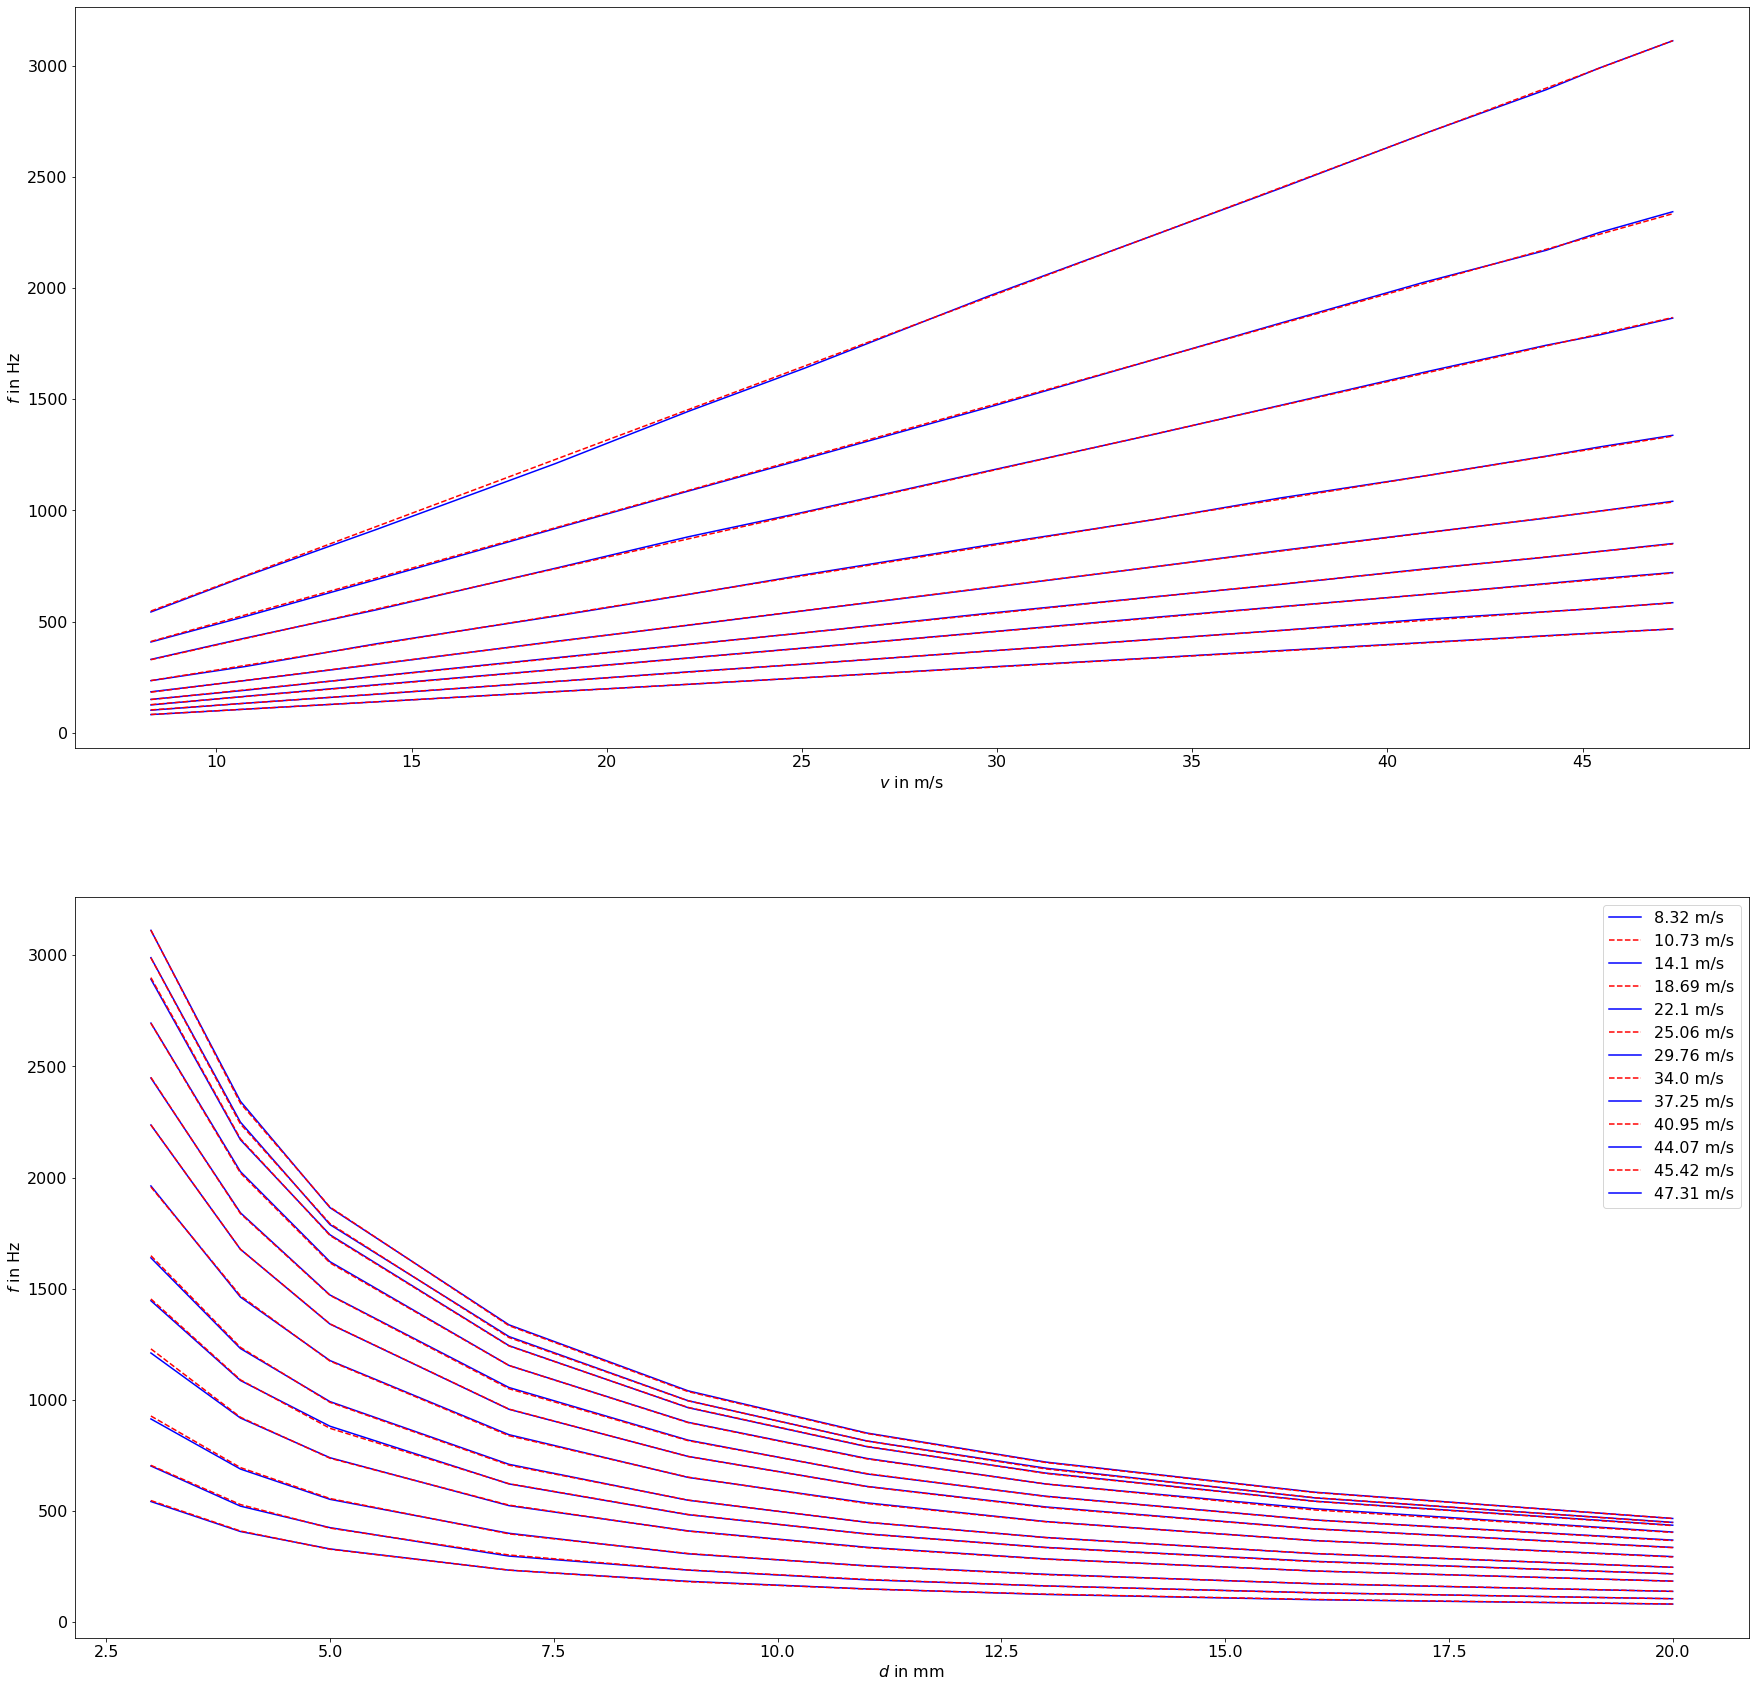

In [48]:
def vec_to_arr(f_model, num_row, num_col):
    f_arr = np.zeros((num_row, num_col))
    for i in range(num_col):
        for j in range(num_row):
            f_arr[j,i]=f_model[i*num_row+j]
    return f_arr

f_model1 = np.matmul(X1, result_m1.x)
f_arr1 = vec_to_arr(f_model1, len(v_list), len(d_list))
f_model2 = np.matmul(X2, result_m2.x)
f_arr2 = vec_to_arr(f_model2, len(v_list), len(d_list))
f_model3 = np.matmul(X3, result_m3.x)
f_arr3 = vec_to_arr(f_model3, len(v_list), len(d_list))
f_model4 = np.matmul(X4, result_m4.x)
f_arr4 = vec_to_arr(f_model4, len(v_list), len(d_list))

fig1 = plt.figure(figsize=(30,30))

ax1 = plt.subplot(2,1,1)
for f, f1, f2, f3, f4 in zip(f_arr.T, f_arr1.T, f_arr2.T, f_arr3.T, f_arr4.T):
    plt.plot(v_list,f, 'b-')
    #plt.plot(v_list,f1, 'r--')
    #plt.plot(v_list,f2, 'r--')
    #plt.plot(v_list,f3, 'r--')
    plt.plot(v_list,f4, 'r--')
plt.xlabel("$v$ in m/s")
plt.ylabel("$f$ in Hz")

ax2 = plt.subplot(2,1,2)
for f, f1, f2, f3, f4 in zip(f_arr, f_arr1, f_arr2, f_arr3, f_arr4):
    plt.plot(d_list,f, 'b-')
    #plt.plot(d_list,f1, 'r--')
    #plt.plot(d_list,f2, 'r--')
    #plt.plot(d_list,f3, 'r--')
    plt.plot(d_list,f4, 'r--')
plt.legend(["".join([str(name), " m/s"]) for name in v_list])
plt.xlabel("$d$ in mm")
plt.ylabel("$f$ in Hz")

**5) Wenden Sie die das Modell an.**
  * Wie hoch ist die Hiebton-Frequenz bei einem Zylinderdurchmesser von 10 mm und einer Strömungsgeschwindigkeit von 20 m/s?
  * Wie groß ist der Durchmesser eines Zylinders, der bei 42 m/s Windgeschwindigkeit mit 1000 Hz pfeift?
  * Wie groß ist die Strömungsgeschwindigkeit, wenn ein Zylinder mit 30 mm Durchmesser einen Ton bei 300 Hz verursacht?

In [65]:
S_r = result_m4.x[0]

d1 = 10
v1 = 20
f1 = S_r*v1/d1
print('Bei einem Durchmesser von {} mm und einer Strömungsgeschwindigkeit von {} m/s ergibt sich eine Hiebtonfrequenz von {:.2f} Hz'.format(d1, v1, f1))

v2 = 42
f2 = 1000
d2 = S_r*v2/f2
print('Bei einer Strömungsgeschwindigkeit von {} m/s und einer Hiebtonfrequenz von {} Hz ergibt sich ein Durchmesser von {:.2f} mm'.format(v2, f2, d2))

d3 = 30
f3 = 300
v3 = d3+f3/S_r
print('Bei einem Durchmesser von {} mm und einer Hiebtonfrequenz von {} Hz ergibt sich eine Strömungsgeschwindigkeit von {:.2f} m/s'.format(d3, f3, v3))

Bei einem Durchmesser von 10 mm und einer Strömungsgeschwindigkeit von 20 m/s ergibt sich eine Hiebtonfrequenz von 394.73 Hz
Bei einer Strömungsgeschwindigkeit von 42 m/s und einer Hiebtonfrequenz von 1000 Hz ergibt sich ein Durchmesser von 8.29 mm
Bei einem Durchmesser von 30 mm und einer Hiebtonfrequenz von 300 Hz ergibt sich eine Strömungsgeschwindigkeit von 31.52 m/s
